<a href="https://colab.research.google.com/github/bielalpha/Tensorflow_study/blob/master/Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Sep 21 23:13:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224,3)
train_test_dir = os.path.join('/content/drive/MyDrive/', 'Disiase')
train_ds = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 709 files belonging to 3 classes.
Using 568 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 709 files belonging to 3 classes.
Using 141 files for validation.


In [ ]:
train_class = train_ds.class_names
train_class

['acne', 'dermatite', 'vitiligo']

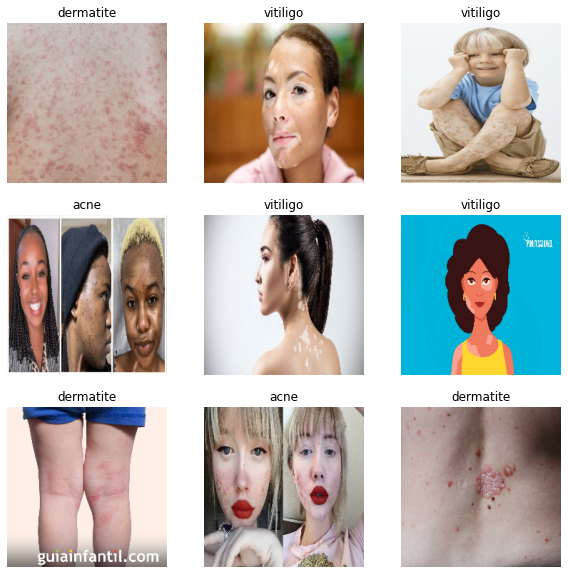

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2)
])

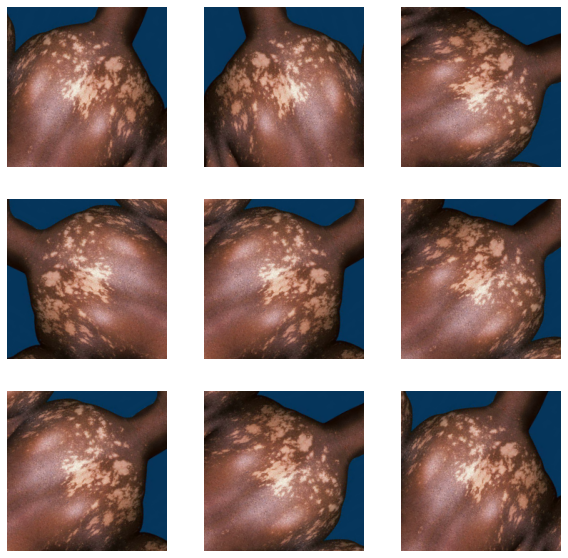

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

base_model = EfficientNetB2(include_top=False,weights='imagenet',input_shape=IMG_SHAPE)

31801344/31790344 [==============================] - 1s 0us/step


In [ ]:
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1408)


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
print(GlobalAveragePooling2D() (feature_batch).shape)

(32, 1408)


In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras import Model

In [ ]:
inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(270, activation='softmax')(x)
model = Model(inputs,outputs)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping


In [ ]:
file_path = 'my_best_model.hdf5'

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=2,
    mode='auto'
)

checkpoint = ModelCheckpoint(
    file_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=2,
    mode='max',
    save_weights_only=False
)

callbacks = [earlyStopping,checkpoint]

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
file_paths = train_ds.file_paths
file_split = []
for x in file_paths:
  data_split = str(x).split('/')
  file_split.append(data_split[-1])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_class), y= train_class)
#model.fit(X_train, y_train, class_weight=class_weights)

In [ ]:
hist = model.fit(
    train_ds,
    epochs = 10,
    validation_data = test_ds,
    verbose = 1,
    callbacks = callbacks)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


18/18 [==============================] - ETA: 0s - loss: 3.3222 - accuracy: 0.4225
Epoch 1: val_accuracy improved from -inf to 0.62411, saving model to my_best_model.hdf5
18/18 [==============================] - 146s 8s/step - loss: 3.3222 - accuracy: 0.4225 - val_loss: 0.8808 - val_accuracy: 0.6241
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.7721 - accuracy: 0.6989
Epoch 2: val_accuracy improved from 0.62411 to 0.76596, saving model to my_best_model.hdf5
18/18 [==============================] - 12s 598ms/step - loss: 0.7721 - accuracy: 0.6989 - val_loss: 0.5641 - val_accuracy: 0.7660
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.8011
Epoch 3: val_accuracy did not improve from 0.76596
18/18 [==============================] - 11s 535ms/step - loss: 0.5194 - accuracy: 0.8011 - val_loss: 0.7615 - val_accuracy: 0.7376
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8556
Epoch 4: va

In [ ]:
new_model = tf.keras.models.load_model('/content/my_best_model.hdf5')

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 270)               380430    
                                                             

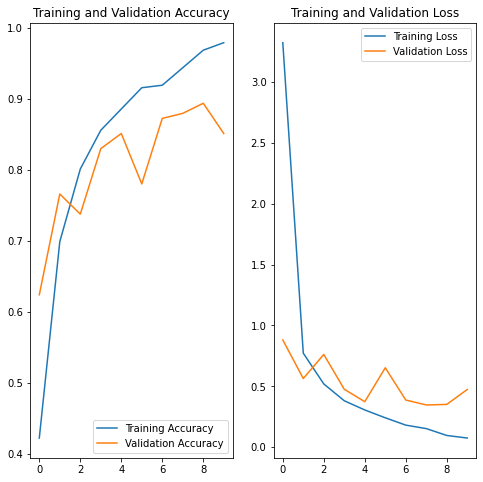

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
disiase_url = "https://images.saymedia-content.com/.image/t_share/MTczOTY0OTAzNjkyOTAzNzMx/backne.jpg"
disiase_path = tf.keras.utils.get_file('acne_998', origin=disiase_url)

img = tf.keras.utils.load_img(
    disiase_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_class[np.argmax(score)], 100 * np.max(score))
)

73728/63788 [==================================] - 0s 0us/step
This image most likely belongs to acne with a 0.88 percent confidence.
